In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
from upsetplot import UpSet

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#000000", "Rapa Adult":"#5a9f68", 
           "Rapa Early":"#4170b0", "Rapa Late":"#c34e0d"}

path = "../analysis/plots/deseq_timepoints/"

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

In [3]:
# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    key = '_'.join(filename.split("_")[0:3])
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

In [4]:
mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
mat[["Comparison", "fullname"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat[["Age", "Sex"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat.drop(columns = ["fullname"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

## Split according to the comparisons we will do
Between sexes  
Within each sex  
Combined sexes

In [5]:
male_df = mer[mer["Sex"] == "M"]
male_df.drop(columns = ["Sex"], inplace = True)
female_df = mer[mer["Sex"] == "F"]
female_df.drop(columns = ["Sex"], inplace = True)
comb_df = mer[mer["Sex"] == "ALL"]
comb_df.drop(columns = ["Sex"], inplace = True)
sexcomp_df = mer[mer["Sex"] == "20240404.csv"]
sexcomp_df.drop(columns = ["Sex"], inplace = True)

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_27077/2379744755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df.drop(columns = ["Sex"], inplace = True)
/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_27077/2379744755.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_df.drop(columns = ["Sex"], inplace = True)
/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_27077/2379744755.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [37]:
x = sexcomp_df[sexcomp_df["Age"] == "Old"]
x[x["Comparison"] == "SexRA"].shape

(77, 17)

In [6]:
lut = dict(zip(['Firmicutes', 'Bacteroidetes', 'Proteobacteria', 'Actinobacteria',
       'Tenericutes', 'Cyanobacteria', 'Patescibacteria',
       'Deferribacteres', 'Fusobacteria'], 
            ["lightgray", "cyan", "gold", "limegreen", "purple", "pink", "orange", "darkolivegreen"]))

In [91]:
def long_and_heatmap(df, nam):
    
    #batches2 = pd.Series(list(df["Phylum"]), index = list(df["OTU"]))
    #lut = dict((k, lut[k]) for k in list(df["Phylum"].unique()))
    #col_batch = batches2.map(lut)

    dfpl = df.loc[:, ["Age", "log2FoldChange", "OTU"]].pivot_table(index = "OTU", 
                        columns = "Age", values = "log2FoldChange")
    dfpl.fillna(0, inplace = True)
    if "Young" in dfpl.columns:
        dfpl = dfpl[["Young",  "Mid", "Old"]]
        sns.set(font="Verdana")
        g = sns.clustermap(dfpl.sort_values(by = ["Young", "Mid", "Old"], ascending = False), 
                       cmap = 'bwr', center = 0, col_cluster = False, row_cluster = False,
                   figsize = [4, 17], yticklabels = False)
    elif "Mid" in dfpl.columns:
        dfpl = dfpl[["Mid", "Old"]]
        sns.set(font="Verdana")
        g = sns.clustermap(dfpl.sort_values(by = ["Mid", "Old"], ascending = False), 
                       cmap = 'bwr', center = 0, col_cluster = False, row_cluster = False,
                   figsize = [3, 17], yticklabels = False)
    else:
        dfpl = dfpl[["Old"]]
        sns.set(font="Verdana")
        g = sns.clustermap(dfpl.sort_values(by = ["Old"], ascending = False), 
                       cmap = 'bwr', center = 0, col_cluster = False, row_cluster = False,
                   figsize = [1.5, 17], yticklabels = False)
    
    g.cax.set_position([1.2, .5, .03, .2])
    g.ax_heatmap.set_xlabel("Age")
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.tick_params(right=False, bottom = False)

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.savefig(f"{path}/{nam}_heatmap_logFC_{new_day}.pdf", bbox_inches='tight')

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/matrix.py:715: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


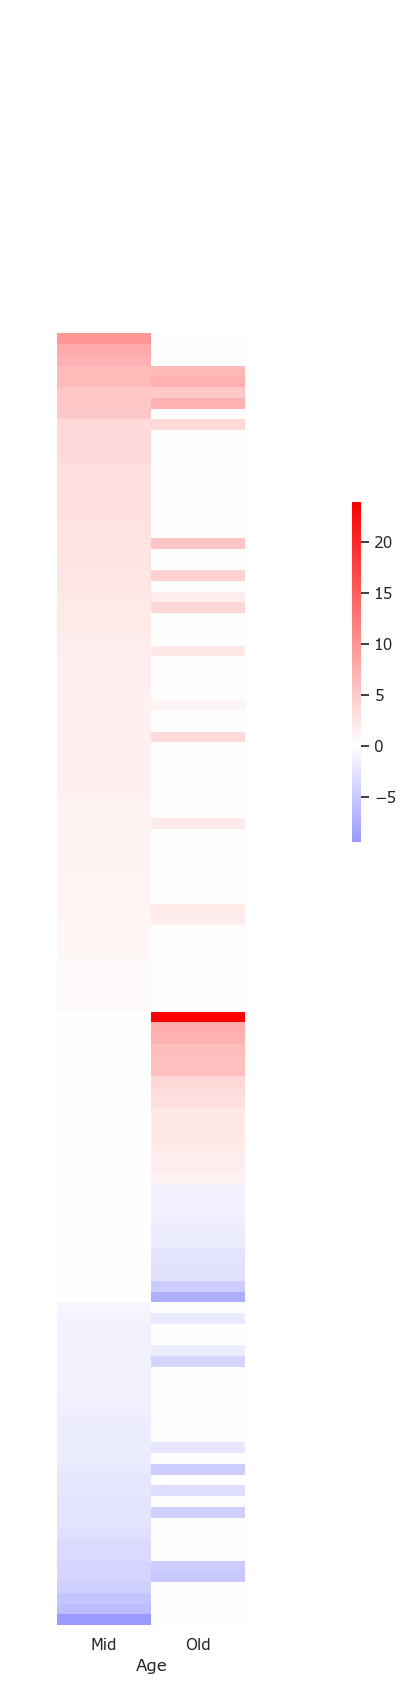

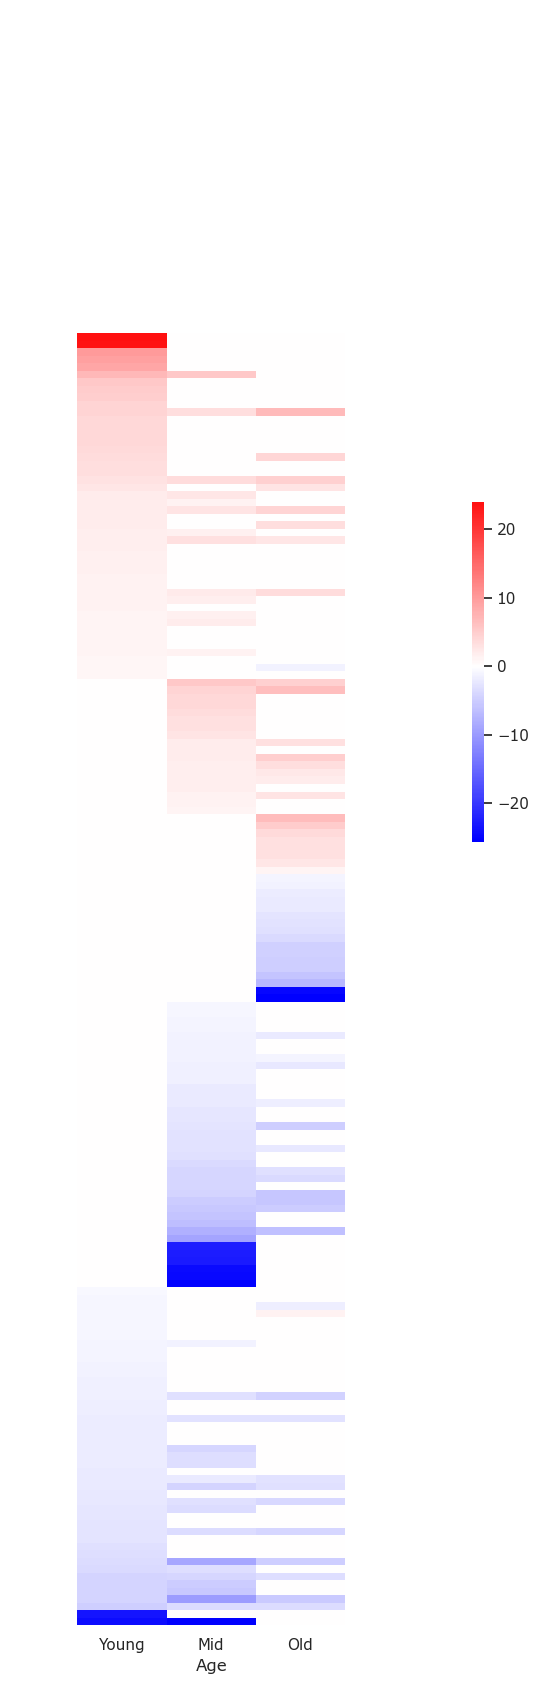

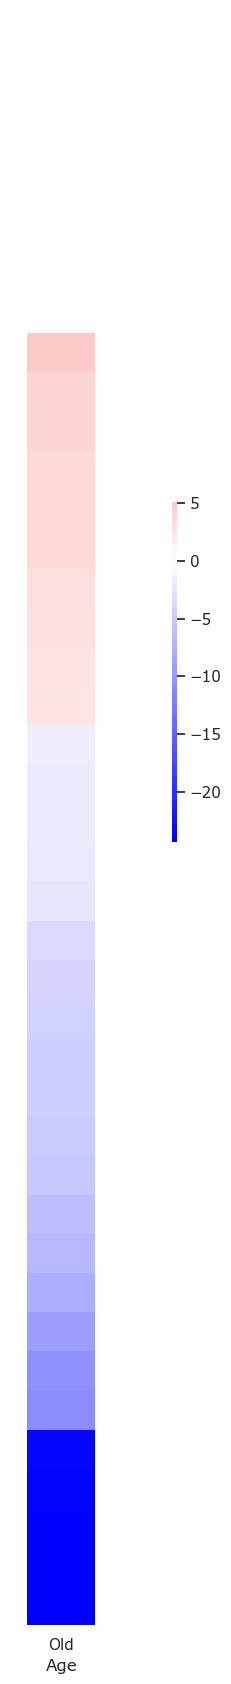

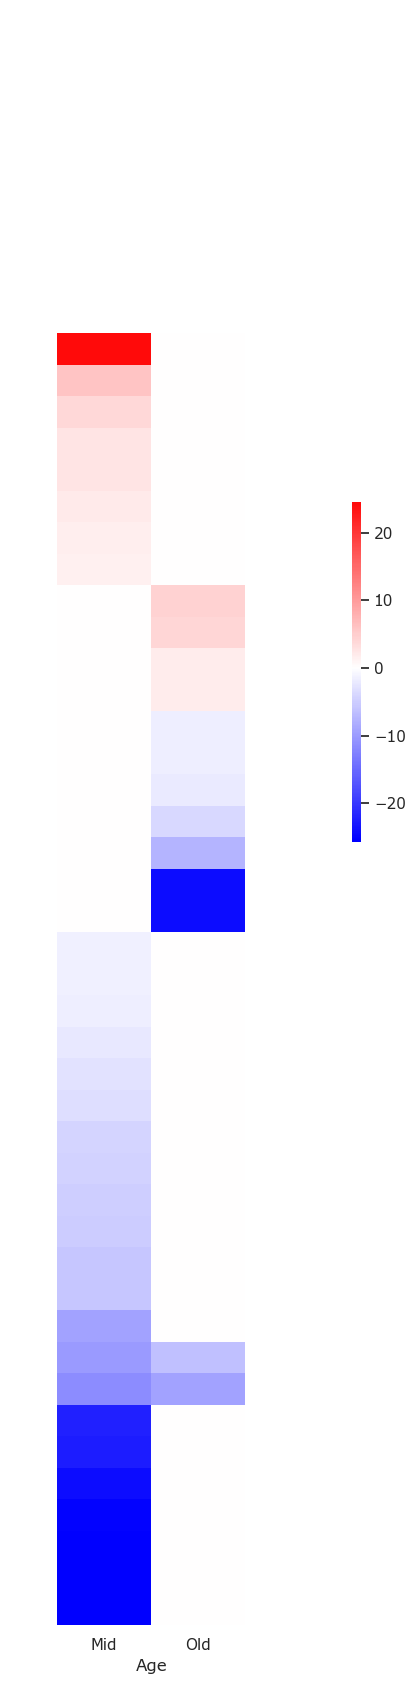

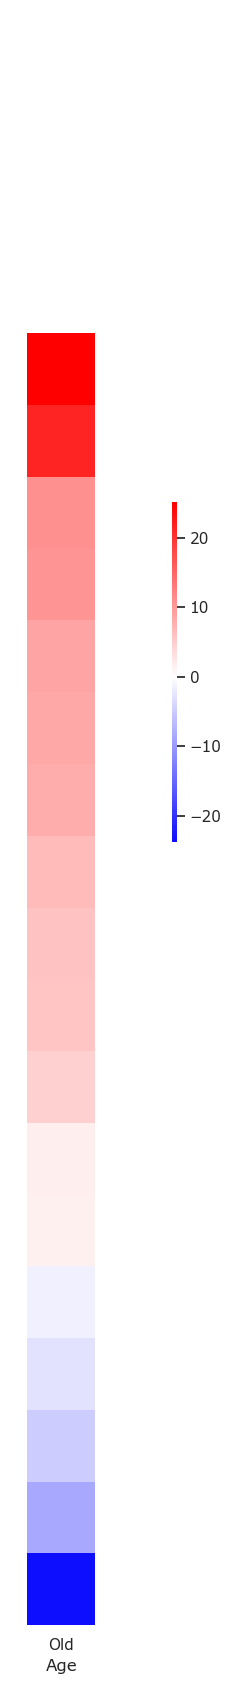

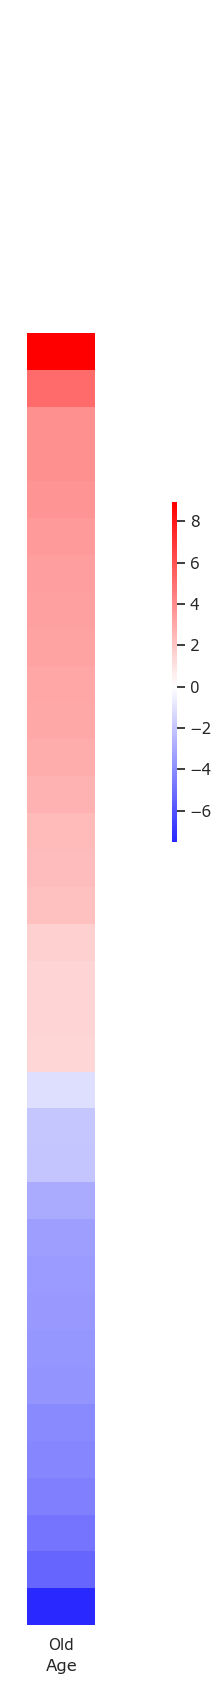

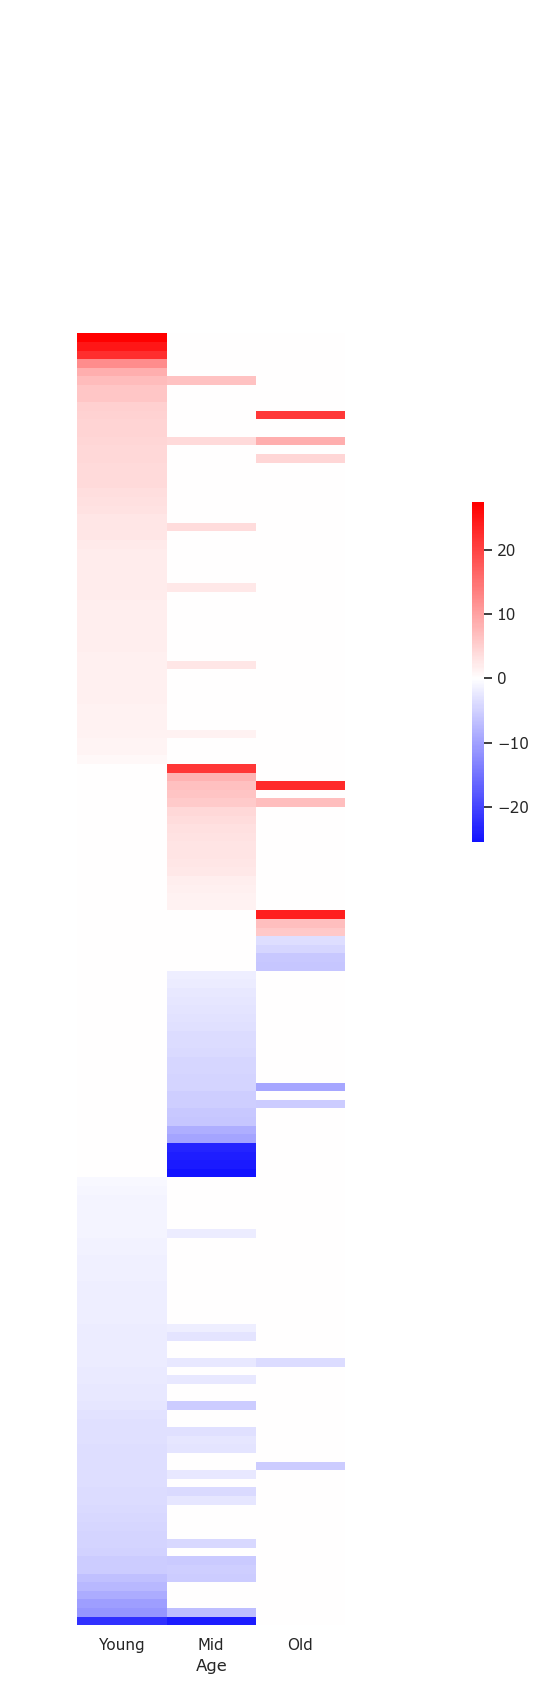

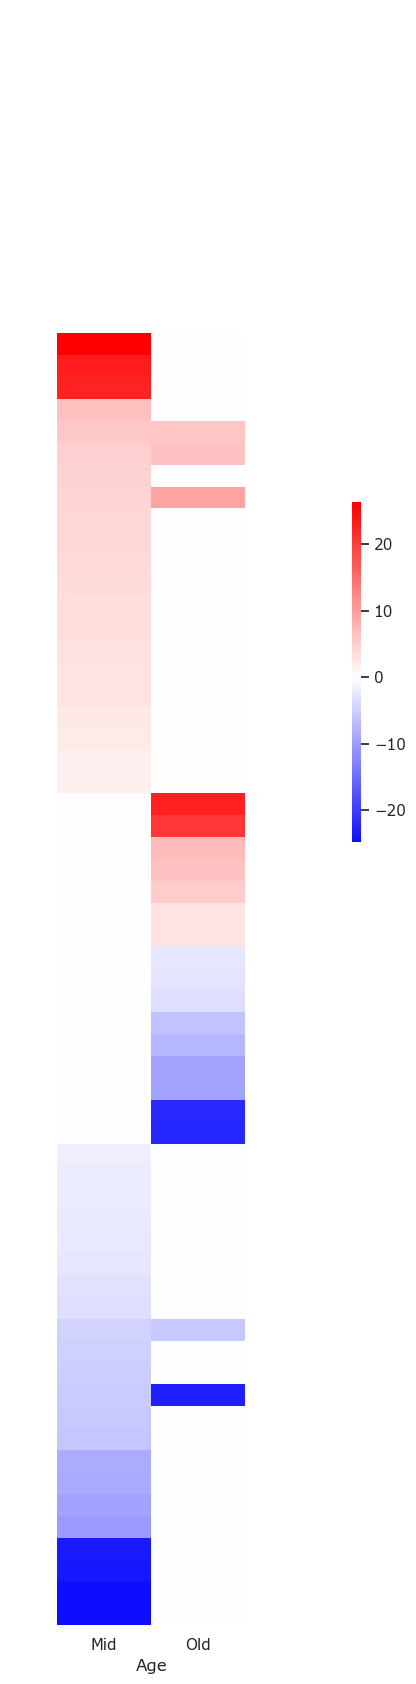

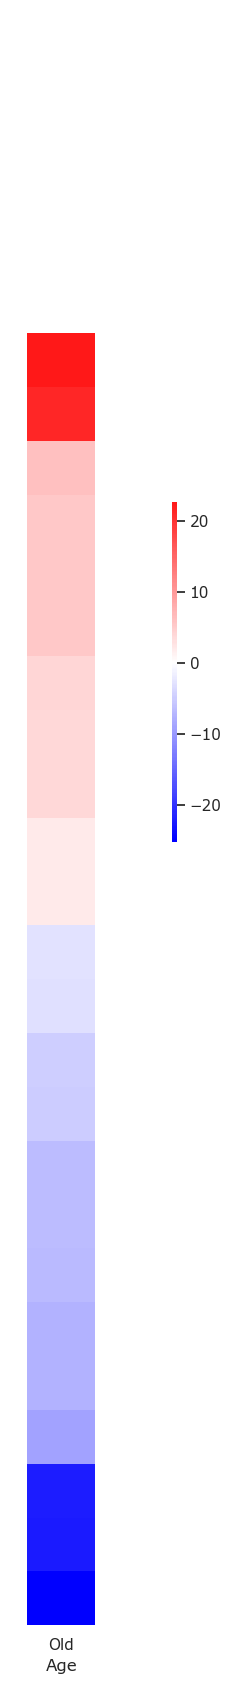

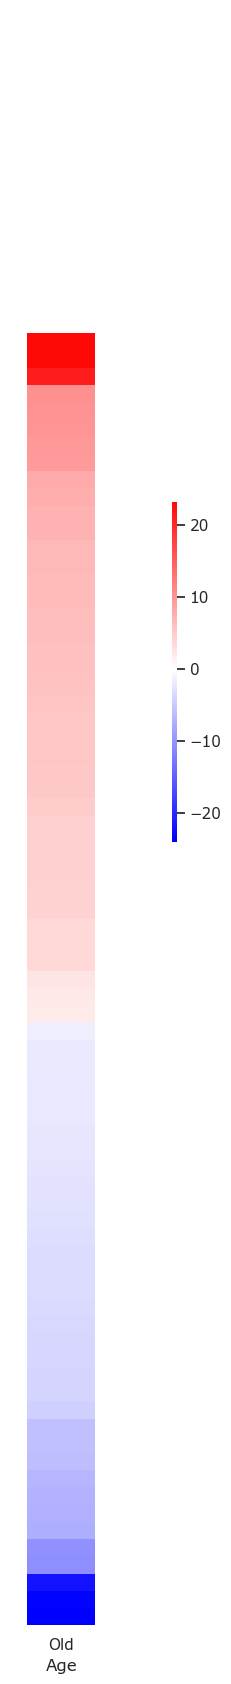

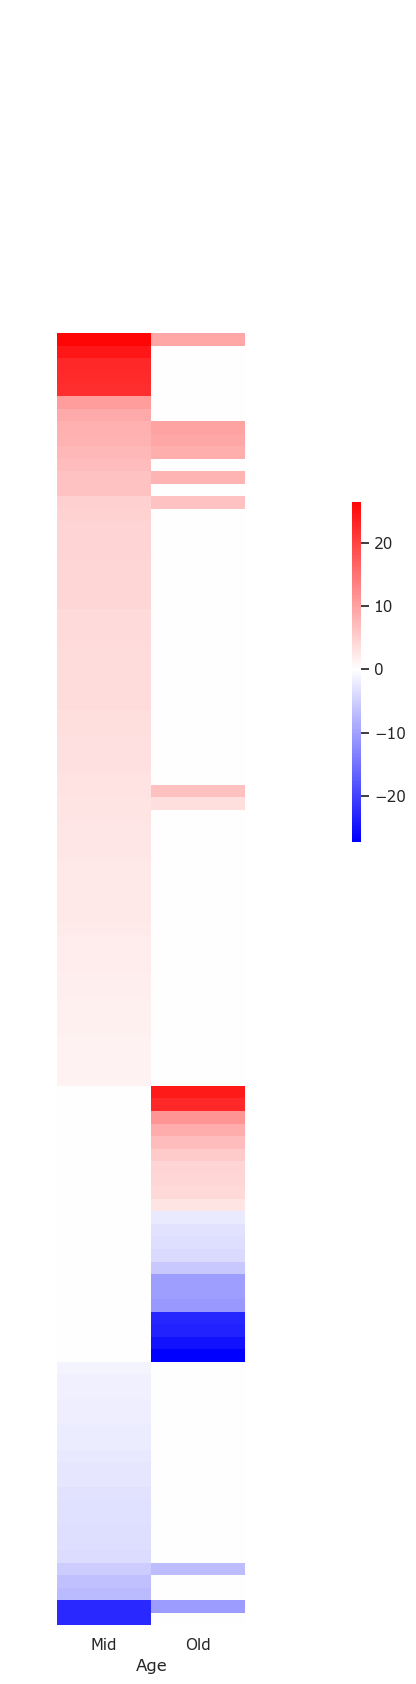

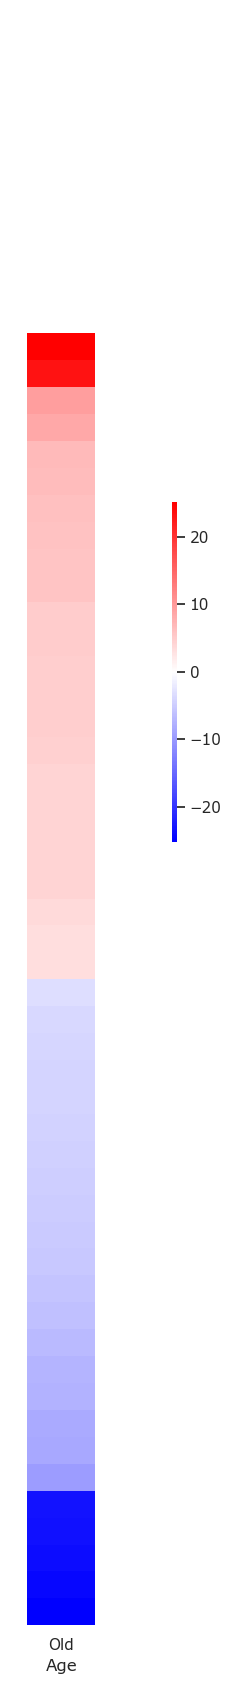

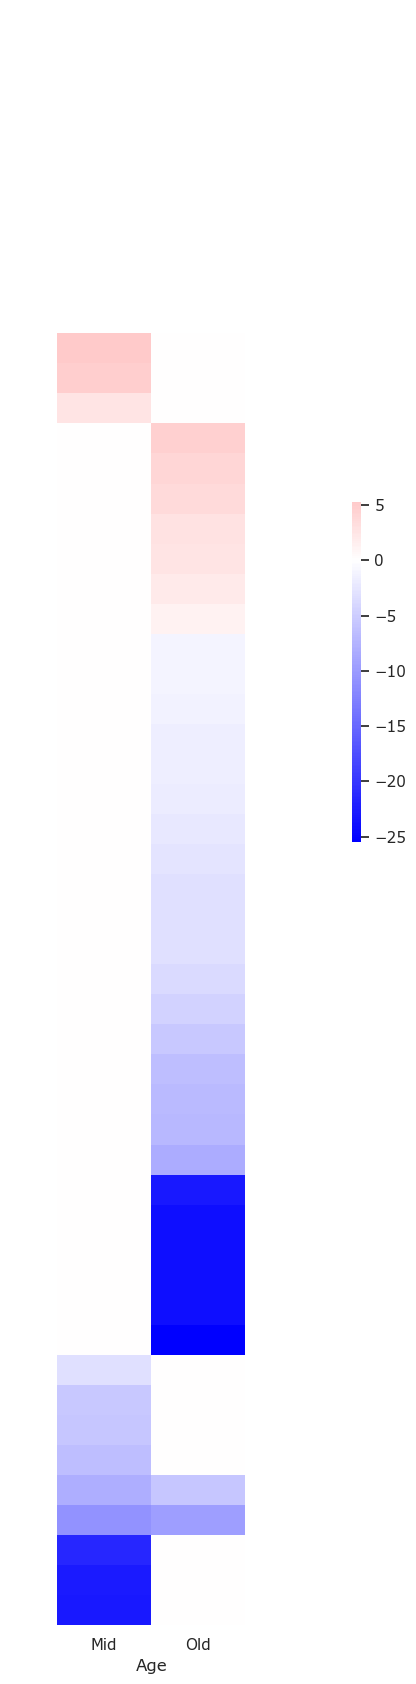

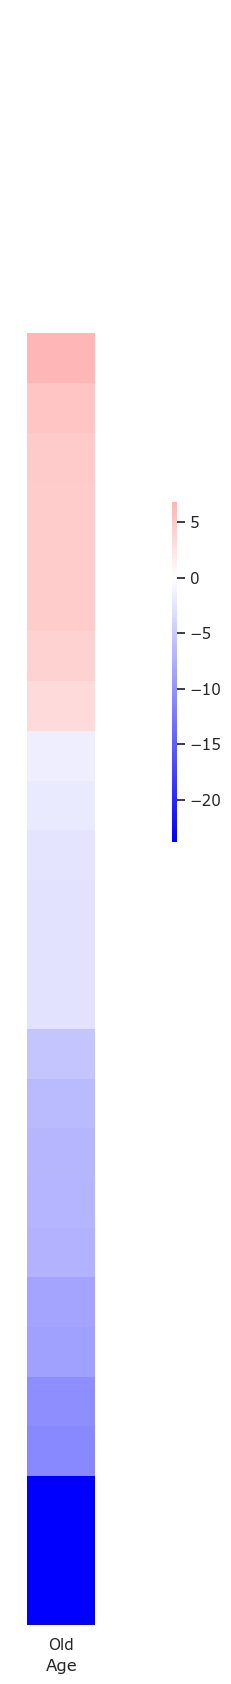

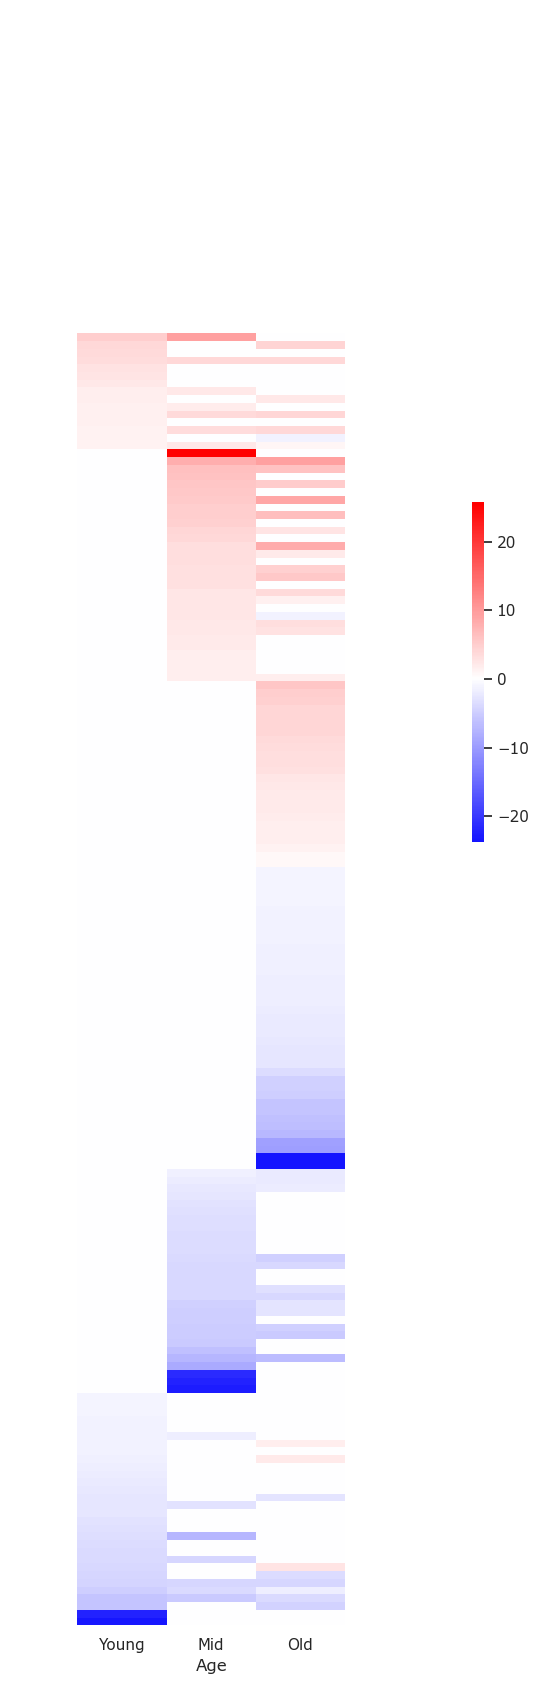

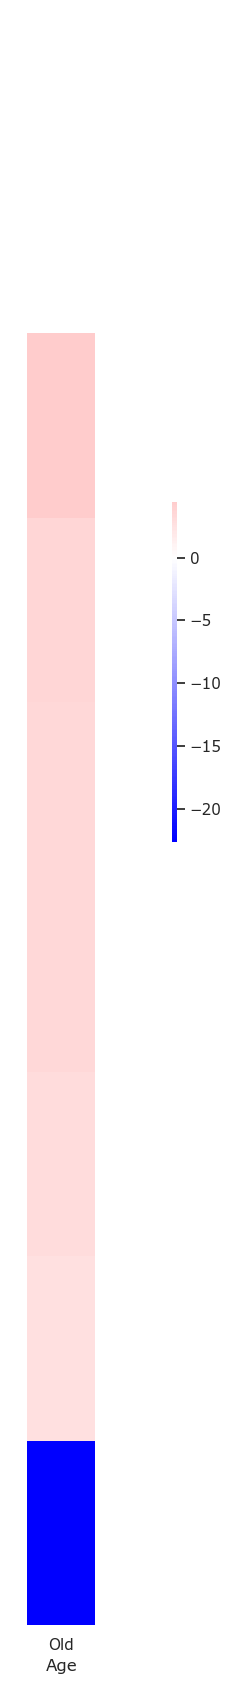

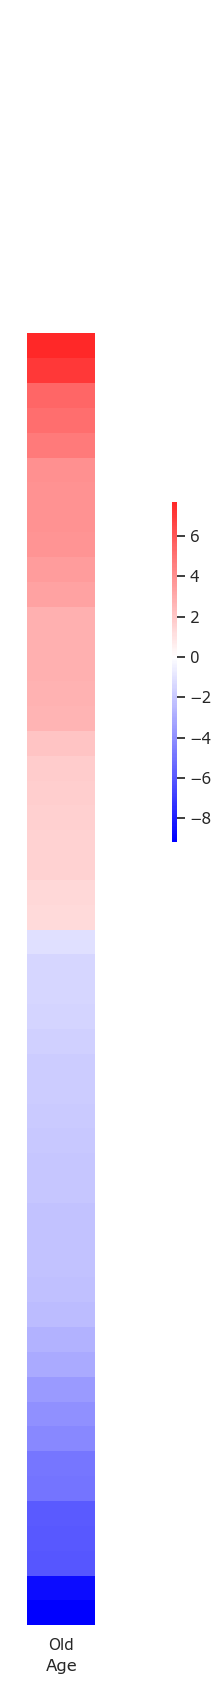

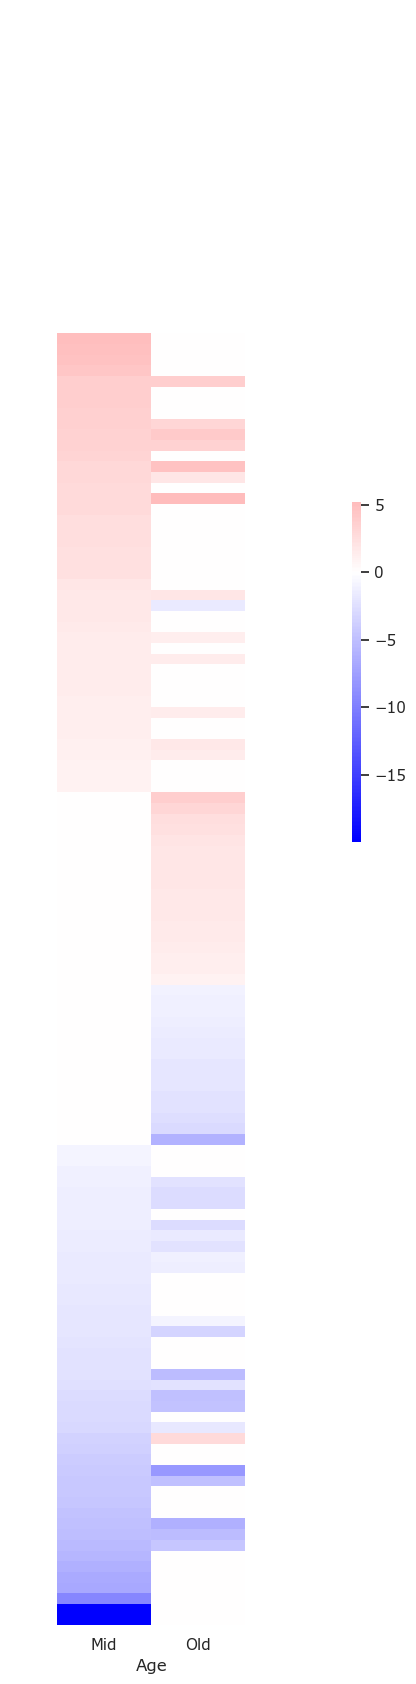

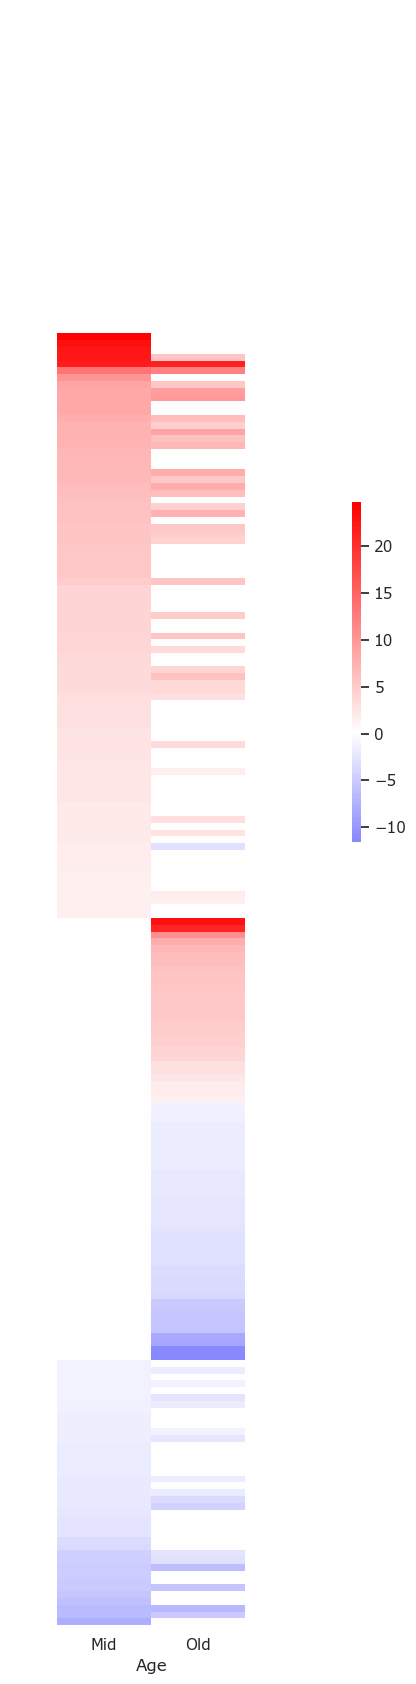

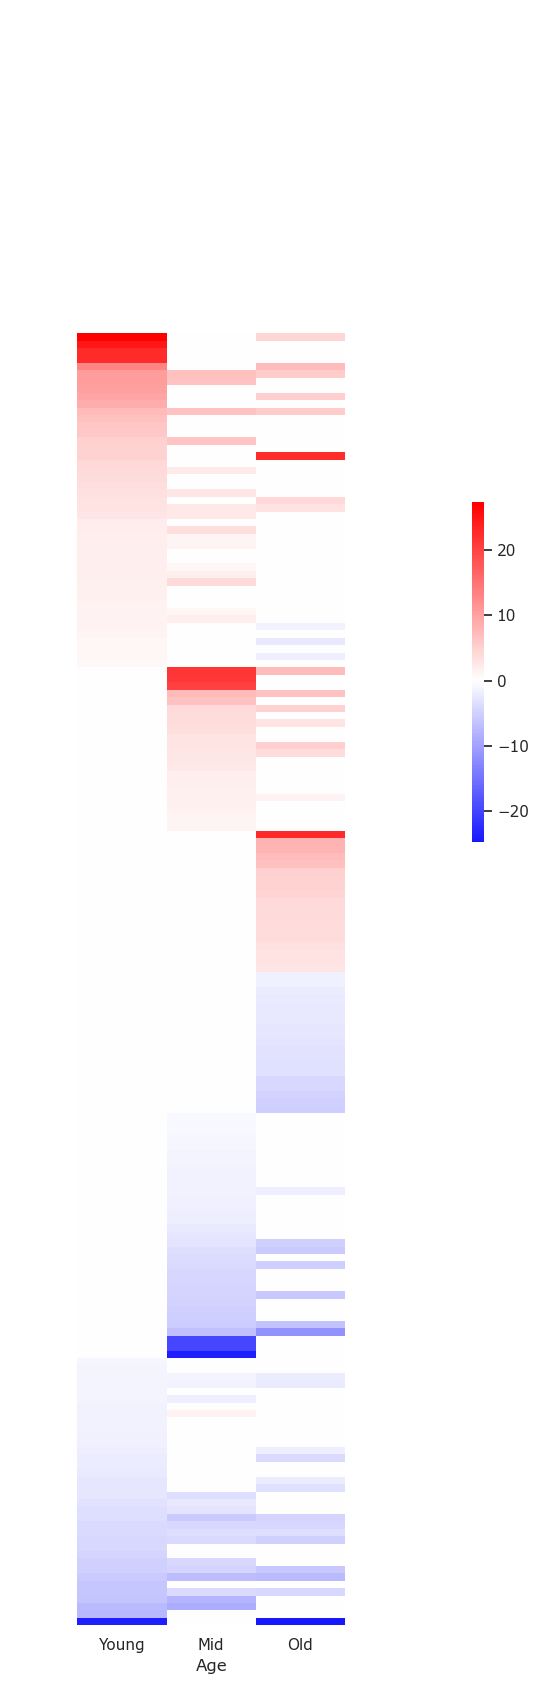

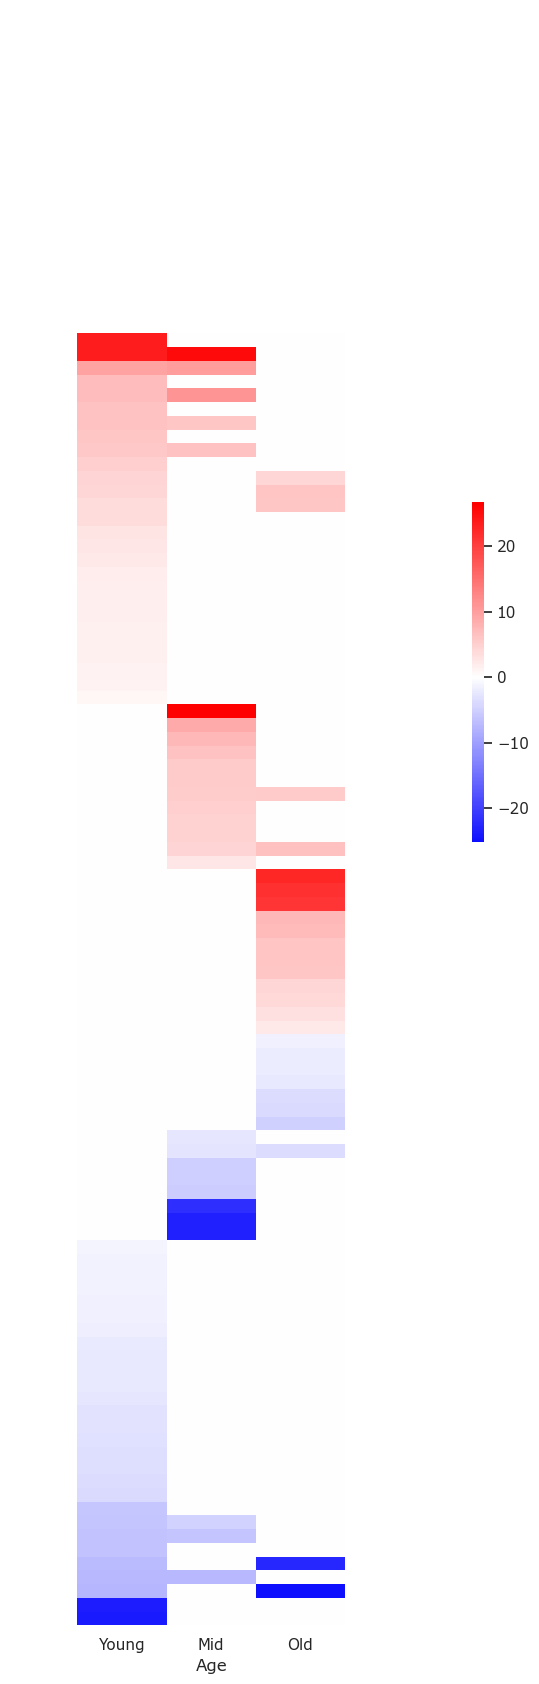

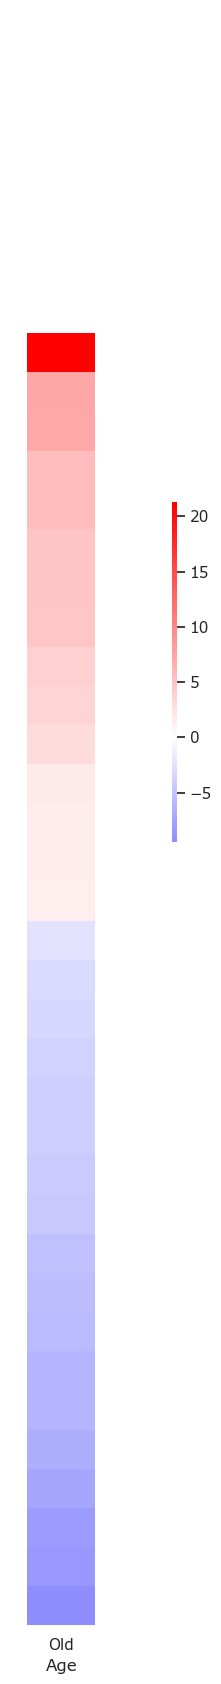

In [92]:
for e in list(comb_df["Comparison"].unique()):

    long_and_heatmap(comb_df[comb_df["Comparison"] == e], e + "_ALL")
    
for e in list(male_df["Comparison"].unique()):

    long_and_heatmap(male_df[male_df["Comparison"] == e], e + "_Males")
    
for e in list(female_df["Comparison"].unique()):

    long_and_heatmap(female_df[female_df["Comparison"] == e], e + "_Females")
    
for e in list(sexcomp_df["Comparison"].unique()):

    long_and_heatmap(sexcomp_df[sexcomp_df["Comparison"] == e], e + "_SexComp")

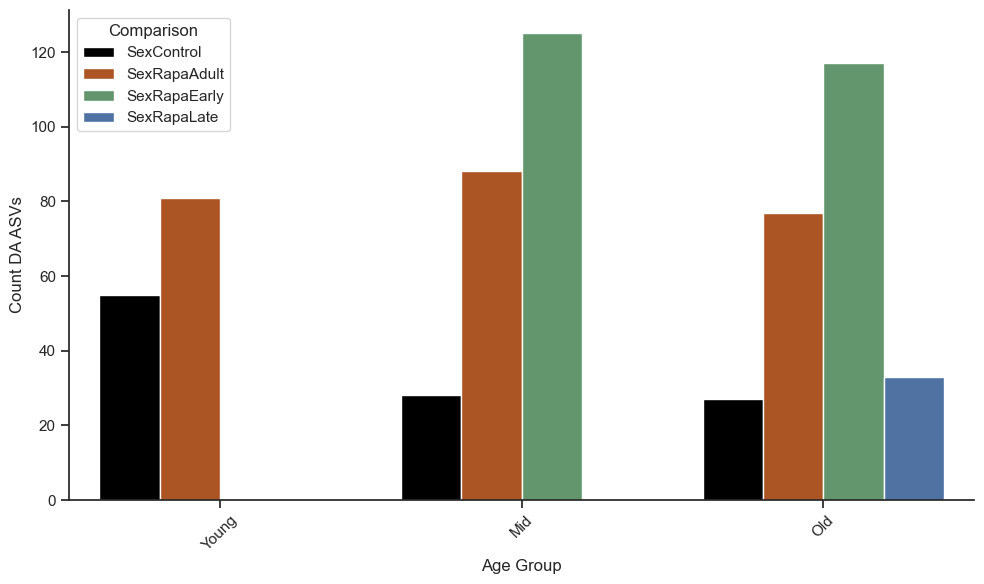

In [7]:
palettesex = {'SexControl': '#000000',
 'SexRapaAdult': '#c34e0d',
 'SexRapaEarly': '#5a9f68',
 'SexRapaLate': '#4170b0'}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize = (10, 6))
# Create the bar plot
sns.countplot(sexcomp_df, x="Age", hue="Comparison", hue_order = ["SexControl", "SexRapaAdult",
                                                                 "SexRapaEarly", "SexRapaLate"],
             palette = palettesex, order = ["Young", "Mid", "Old"])

plt.xlabel("Age Group")
plt.ylabel("Count DA ASVs")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.show()

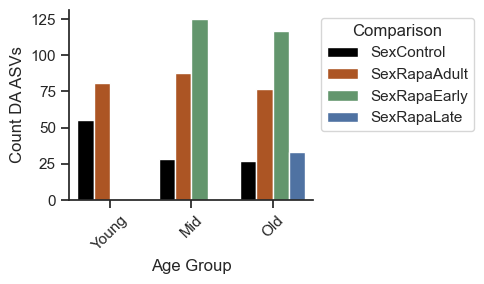

In [94]:
def barplots_numdif(df, hue_order, palette, nam):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)

    fig, ax = plt.subplots(figsize = (5, 3))
    # Create the bar plot
    sns.countplot(df, x="Age", hue="Comparison", hue_order = hue_order,
                 palette = palettesex, order = ["Young", "Mid", "Old"])

    plt.xlabel("Age Group")
    plt.ylabel("Count DA ASVs")
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(f"{path}/{nam}_barplot_difabund_{new_day}.pdf", bbox_inches='tight')
    
barplots_numdif(sexcomp_df, ["SexControl", "SexRapaAdult","SexRapaEarly", "SexRapaLate"], palettesex, "sexcomp")

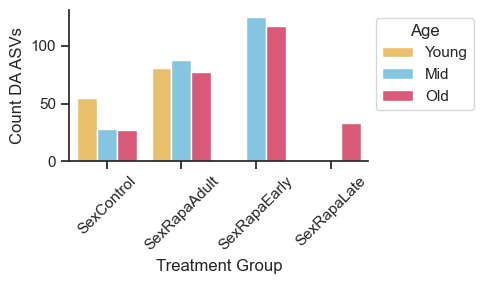

In [8]:
paletteage = {"Young":"#FDC659", "Mid":"#74CDF0", "Old":"#EE446F"}
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize = (5, 3))
# Create the bar plot
sns.countplot(sexcomp_df, x="Comparison", hue="Age", 
                 hue_order = ["Young", "Mid", "Old"], order = ["SexControl", "SexRapaAdult","SexRapaEarly", "SexRapaLate"], palette = paletteage)

plt.xlabel("Treatment Group")
plt.ylabel("Count DA ASVs")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/sexcompbyage_barplot_difabund_{new_day}.pdf", bbox_inches='tight')

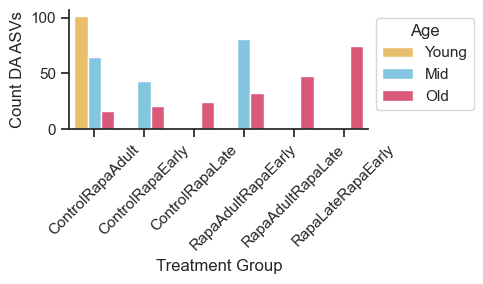

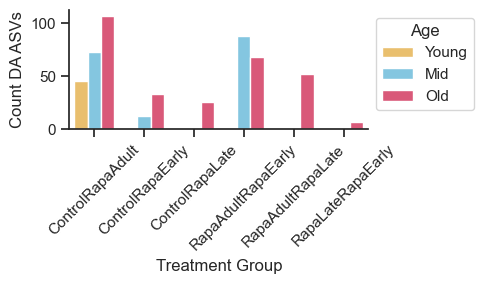

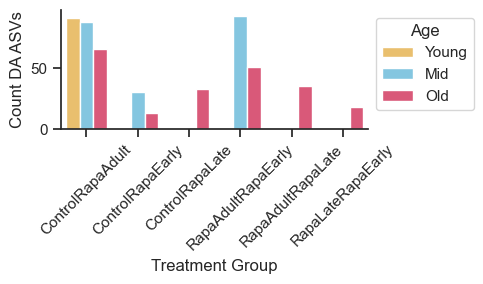

In [98]:
def barplots_numdif2(df, paletteage, nam):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)

    fig, ax = plt.subplots(figsize = (5, 3))
    # Create the bar plot
    sns.countplot(df, x="Comparison", hue="Age", 
                 hue_order = ["Young", "Mid", "Old"], order = ["ControlRapaAdult", "ControlRapaEarly", "ControlRapaLate",
                    "RapaAdultRapaEarly", "RapaAdultRapaLate", "RapaLateRapaEarly"], palette = paletteage)

    plt.xlabel("Treatment Group")
    plt.ylabel("Count DA ASVs")
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(f"{path}/{nam}_barplot_difabund_{new_day}.pdf", bbox_inches='tight')
    
barplots_numdif2(male_df, paletteage, "malecomp")
barplots_numdif2(female_df, paletteage, "femalecomp")
barplots_numdif2(comb_df, paletteage, "combinedcomp")

In [9]:
mer["Genus"].unique() ['Candidatus_Arthromitus', 'Lachnospiraceae_UCG-001', 
                      'Ruminiclostridium_5', 'Lachnoclostridium',
                      'Lachnospiraceae_NK4A136_group']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [10]:
for e in ['Candidatus_Arthromitus', 'Lachnospiraceae_UCG-001', 
                      'Ruminiclostridium_5', 'Lachnoclostridium',
                      'Lachnospiraceae_NK4A136_group']:
    display(mer[mer["Genus"] == e])

,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
540,TACGTAGGTGGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGGATG...,2.417387,4.676004,1.660519,2.815990,0.004863,0.026683,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Candidatus_Arthromitus,SexRapaEarly,Old,20240404.csv,Bacteria_Firmicutes_Clostridia_Clostridiales_C...,ASV_694
1210,TACGTAGGTGGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGGATG...,3.238892,5.191363,1.850143,2.805926,0.005017,0.038460,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Candidatus_Arthromitus,RapaLateRapaEarly,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_C...,ASV_694
1948,TACGTAGGTGGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGGATG...,1.879857,-4.466720,1.616498,-2.763208,0.005724,0.036402,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Candidatus_Arthromitus,RapaAdultRapaEarly,Mid,F,Bacteria_Firmicutes_Clostridia_Clostridiales_C...,ASV_694


,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
16,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,868.054396,3.366254,0.558719,6.024953,1.691585e-09,2.723452e-07,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_20
27,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,292.484024,3.050459,0.594827,5.128316,2.923460e-07,1.870466e-05,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_55
134,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,419.120484,-2.931407,0.957131,-3.062702,2.193487e-03,2.790862e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,ControlRapaAdult,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_20
142,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,158.110274,-3.256431,0.999686,-3.257455,1.124161e-03,1.694481e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,ControlRapaAdult,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_55
308,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,581.286471,-1.983771,0.728055,-2.724756,6.434902e-03,4.510583e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,ControlRapaAdult,Young,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_20
320,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,175.398052,-1.990165,0.717415,-2.774078,5.535840e-03,4.257813e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,ControlRapaAdult,Young,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_55
454,TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,136.010320,10.909310,2.198095,4.963075,6.938592e-07,2.203003e-05,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,SexRapaEarly,Old,20240404.csv,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_133
490,TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,32.141225,8.012223,1.888336,4.243006,2.205456e-05,3.501162e-04,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,SexRapaEarly,Old,20240404.csv,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_279
523,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,6.001717,5.820319,1.627355,3.576552,3.481567e-04,4.031177e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,SexRapaEarly,Old,20240404.csv,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_425
636,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,13.801267,-7.263811,1.935889,-3.752183,1.753017e-04,1.916886e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,SexRapaAdult,Young,20240404.csv,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_341


,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
88,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,3.908673,2.533444,0.796759,3.179685,1.474353e-03,1.137231e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
126,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,10.236615,6.808632,1.092552,6.231860,4.609290e-10,5.577241e-08,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ControlRapaLate,Old,F,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
163,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,12.294253,3.119816,1.004301,3.106455,1.893449e-03,2.553304e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ControlRapaAdult,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
184,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,7.004207,-3.834853,1.140621,-3.362076,7.735892e-04,1.321732e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ControlRapaAdult,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
259,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,37.131315,2.479351,0.623238,3.978175,6.944628e-05,1.011056e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ControlRapaAdult,Old,F,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
285,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,1.378864,3.954017,1.425541,2.773697,5.542333e-03,3.266018e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ControlRapaAdult,Old,F,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
474,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,31.219504,-3.642751,0.799645,-4.555458,5.227145e-06,1.264471e-04,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,SexRapaEarly,Old,20240404.csv,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
674,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,7.332220,6.531163,1.880250,3.473561,5.136014e-04,2.165686e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,SexControl,Old,20240404.csv,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
865,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,29.839493,1.941352,0.576277,3.368781,7.550132e-04,1.325468e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ControlRapaEarly,Old,F,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
1013,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,25.665631,1.804813,0.640805,2.816478,4.855338e-03,3.458679e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ControlRapaAdult,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216


,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
47,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,84.153083,1.484428,0.450631,3.294112,9.873305e-04,8.831123e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_138
52,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,63.440077,1.715154,0.514508,3.333583,8.573521e-04,8.282022e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_167
64,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,16.927939,2.230852,0.404733,5.511910,3.549597e-08,4.107838e-06,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_220
73,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,9.479106,6.416977,1.340220,4.788001,1.684506e-06,8.136166e-05,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_276
86,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,10.114360,1.908612,0.588618,3.242533,1.184723e-03,1.021823e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,84.543876,2.127236,0.637020,3.339354,8.397362e-04,1.260363e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_167
1987,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,27.288679,1.768067,0.489021,3.615520,2.997453e-04,5.188694e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_220
1991,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,12.923675,6.575629,1.353156,4.859476,1.176968e-06,6.564866e-05,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_276
2107,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,45.759801,8.516022,1.493897,5.700540,1.194283e-08,4.290231e-07,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RapaAdultRapaEarly,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_276


,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
1,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,146.053101,-10.759683,2.585369,-4.161759,3.158059e-05,2.384571e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ControlRapaEarly,Mid,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_46
4,TACGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGAG...,44.923934,-3.195846,0.773732,-4.130432,3.620823e-05,2.384571e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ControlRapaEarly,Mid,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_163
21,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,541.492473,1.654163,0.517695,3.195248,1.397109e-03,1.137231e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_31
30,TACGTAGGGGGCAAGCGTTATCCGGAATCACTGGGTGTAAAGGGAG...,236.674069,-1.593766,0.332152,-4.798308,1.600120e-06,8.136166e-05,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_71
61,TACGTAGGGGGCAAGCGTTATCCGGAATCACTGGGTGTAAAGGGAG...,38.171460,-1.758083,0.392959,-4.473961,7.678366e-06,3.076883e-04,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,RapaAdultRapaEarly,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,695.871507,9.298480,1.938518,4.796695,1.613053e-06,5.380683e-05,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,RapaAdultRapaEarly,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_84
2095,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,320.344805,-27.268458,2.164385,-12.598710,2.146269e-36,1.002308e-33,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,RapaAdultRapaEarly,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_127
2122,TACGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGAG...,1159.988368,1.509208,0.516771,2.920457,3.495181e-03,3.887323e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ControlRapaAdult,Young,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_12
2138,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,32.925211,3.799291,1.297210,2.928816,3.402552e-03,3.878910e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ControlRapaAdult,Young,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_127


In [11]:
mer["Comparison"].unique()

array(['ControlRapaEarly', 'RapaAdultRapaEarly', 'ControlRapaLate',
       'ControlRapaAdult', 'SexRapaEarly', 'RapaLateRapaEarly',
       'SexRapaAdult', 'SexControl', 'RapaAdultRapaLate', 'SexRapaLate'],
      dtype=object)

In [12]:
x = male_df[male_df["Age"] == "Young"]
maleyoung = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = male_df[male_df["Age"] == "Mid"]
malemid = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = male_df[male_df["Age"] == "Old"]
maleold = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]

x = female_df[female_df["Age"] == "Young"]
femaleyoung = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = female_df[female_df["Age"] == "Mid"]
femalemid = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = female_df[female_df["Age"] == "Old"]
femaleold = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/2702403539.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


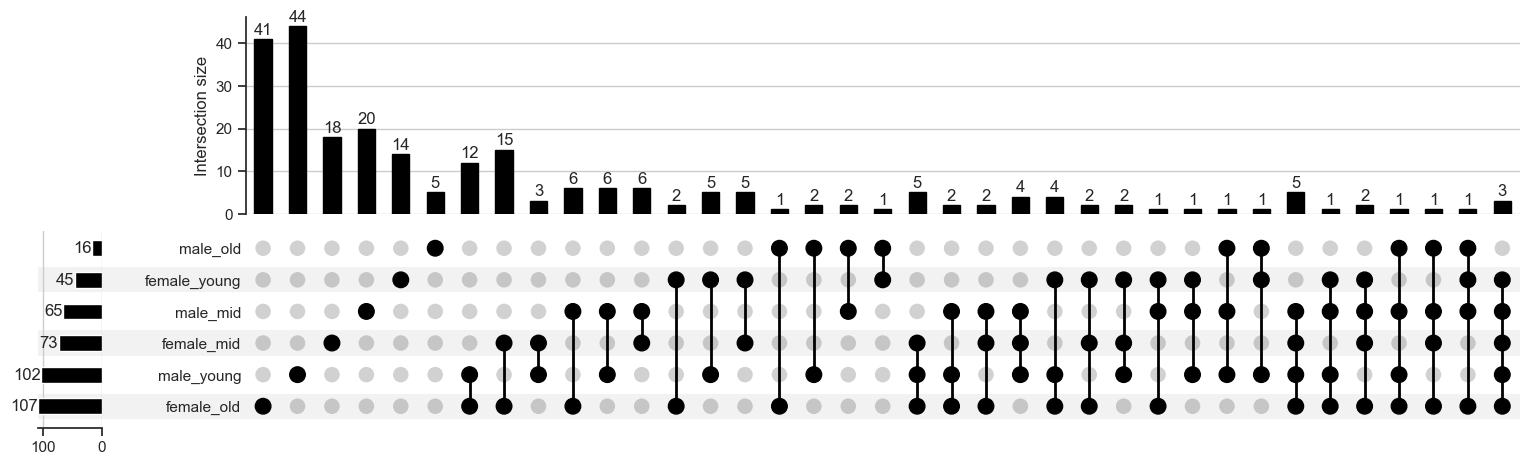

In [101]:
from upsetplot import UpSet
changes = from_contents(
    {"female_young": femaleyoung, "female_mid": femalemid, "female_old": femaleold,
    "male_young":maleyoung, "male_mid":malemid, "male_old":maleold}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("all_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/1201158616.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


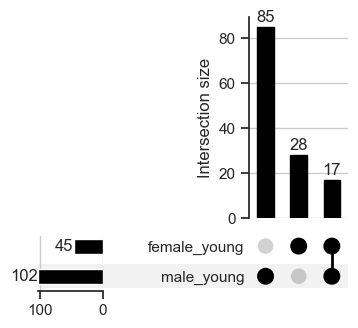

In [102]:
changes = from_contents(
    {"male_young":maleyoung, "female_young":femaleyoung}
)
ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("young_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/1432408389.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


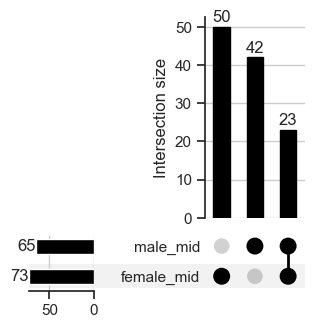

In [103]:
changes = from_contents(
    {"male_mid":malemid, "female_mid":femalemid}
)
ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("mid_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/2830356902.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


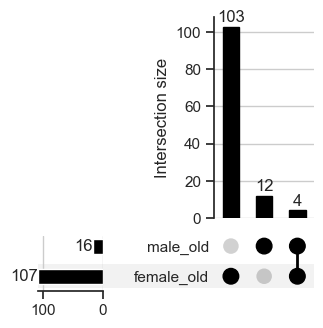

In [104]:
changes = from_contents(
    {"male_old":maleold, "female_old":femaleold}
)
ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("old_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/1105282720.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


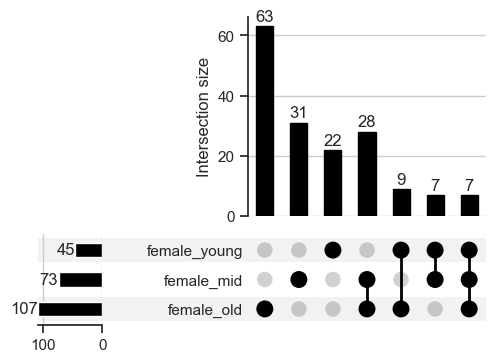

In [105]:
changes = from_contents(
    {"female_young": femaleyoung, "female_mid": femalemid, "female_old": femaleold}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("females_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/2352233706.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


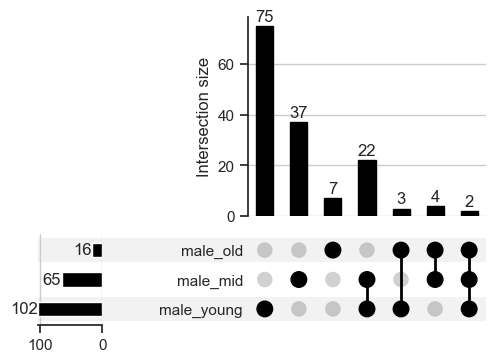

In [106]:
changes = from_contents(
    {"male_young": maleyoung, "male_mid": malemid, "male_old": maleold}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("males_ContRA.pdf")

In [ ]:
x = male_df[male_df["Age"] == "Young"]
maleyoung = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = male_df[male_df["Age"] == "Mid"]
malemid = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = male_df[male_df["Age"] == "Old"]
maleold = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]

x = female_df[female_df["Age"] == "Young"]
femaleyoung = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = female_df[female_df["Age"] == "Mid"]
femalemid = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = female_df[female_df["Age"] == "Old"]
femaleold = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]

